In [9]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson
import seaborn as sns

"""
Hyper parameters
<int> MAX_NUM: 每个停车场能停的最大数目（20）
<int> lam1_rent: 停车场1租车λ值（3）
<int> lam1_return: 停车场1还车λ值（3）
<int> lam2_rent: 停车场2租车λ值（4）
<int> lam2_return: 停车场2还车λ值（2）
<int> MAX_ACTION: 最大移动汽车数目（5）
<int> CAR_COST: 移动车辆的代价（2）
<int> CAR_EARNING: 租车的收入（10）
<float> DISCOUNT: 收益折扣（0.9）
<np.array> actions: 动作集合（-5，-4，…，4，5）
<int> POISSON_UPPER_BOUND: 限制泊松分布产生请求数目的上限
<dict> poisson_cache: 存储每个（n，λ）对应的泊松概率，key为n*(POISSON_UPPER_BOUND-1)+lam
"""
MAX_NUM = 20
lam1_rent = 3
lam1_return = 3
lam2_rent = 4
lam2_return = 2
MAX_ACTION = 5
DISCOUNT = 0.9
CAR_COST = 2
CAR_EARNING = 10
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)
POISSON_UPPER_BOUND = 11
poisson_cache = dict()


def poisson_prob(n, lam):
    global poisson_cache
    key = n * (POISSON_UPPER_BOUND - 1) + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]


class dp:
    def __init__(self):
        self.v = np.ones((MAX_NUM + 1, MAX_NUM + 1), float)
        self.actions = np.zeros((MAX_NUM + 1, MAX_NUM + 1), int)
        self.gama = DISCOUNT
        self.delta = 0
        self.theta = 0.01
        pass

    def state_value(self, state, action, state_value, constant_returned_cars):
        """

        :param state: 状态定义为每个地点的车辆数
        :param action: 车辆的移动数量[-5,5]，负：2->1，正：1->2
        :param state_value: 状态价值矩阵
        :param constant_returned_cars: 将换车的数目设定为泊松均值，替换为泊松概率分布
        :return:
        """
        # initial total return
        returns = 0.0

        # 移动车辆产生负收益
        returns -= CAR_COST * abs(action)

        # 移动后的车辆总数不能超过20
        NUM_OF_CARS_1 = min(state[0] - action, MAX_NUM)
        NUM_OF_CARS_2 = min(state[1] + action, MAX_NUM)

        # 遍历两地全部的可能概率下（截断泊松概率）租车请求数目
        for rent_1 in range(POISSON_UPPER_BOUND):
            for rent_2 in range(POISSON_UPPER_BOUND):
                # prob为两地租车请求的联合概率，概率为泊松分布
                prob = poisson_prob(rent_1, lam1_rent) * poisson_prob(rent_2, lam2_rent)
                # 两地原本汽车数量
                num_of_cars_1 = NUM_OF_CARS_1
                num_of_cars_2 = NUM_OF_CARS_2
                # 有效租车数目必须小于等于该地原有的车辆数目
                valid_rent_1 = min(num_of_cars_1, rent_1)
                valid_rent_2 = min(num_of_cars_2, rent_2)
                # 计算回报，更新两地车辆数目变动
                reward = (valid_rent_1 + valid_rent_2) * CAR_EARNING
                num_of_cars_1 -= valid_rent_1
                num_of_cars_2 -= valid_rent_2
                # 如果还车数目为泊松分布的均值
                if constant_returned_cars:
                    # 两地的还车数目均为泊松分布均值
                    returned_cars_1 = lam1_return
                    returned_cars_2 = lam2_return
                    # 还车后总数不能超过车场容量
                    num_of_cars_first_loc = min(num_of_cars_1 + returned_cars_1, MAX_NUM)
                    num_of_cars_second_loc = min(num_of_cars_2 + returned_cars_2, MAX_NUM)
                    # 核心：
                    # 策略评估：V(s) = p(s',r|s,π(s))[r + γV(s')]
                    returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])

                # 否则计算所有泊松概率分布下的还车空间
                else:
                    for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                        for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                            prob_return = poisson_prob(
                                returned_cars_first_loc, lam1_return) * poisson_prob(
                                returned_cars_second_loc, lam2_return)
                            num_of_cars_first_loc_ = min(num_of_cars_1 + returned_cars_first_loc, MAX_NUM)
                            num_of_cars_second_loc_ = min(num_of_cars_2 + returned_cars_second_loc, MAX_NUM)
                            # 联合概率为【还车概率】*【租车概率】
                            prob_ = prob_return * prob
                            returns += prob_ * (reward + DISCOUNT *
                                                state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
        return returns

    def policy_iteration(self, constant_returned_cars=True):
        """

        :param constant_returned_cars:
        :return:
        """
        # 设置迭代参数
        iterations = 0

        # 准备画布大小，并准备多个子图
        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        # 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        # 这里将子图形成一个1*6的列表
        axes = axes.flatten()
        while True:
            # 使用seaborn的heatmap作图
            # flipud为将矩阵进行垂直角度的上下翻转，第n行变为第一行，第一行变为第n行，如此。
            # cmap:matplotlib的colormap名称或颜色对象；
            # 如果没有提供，默认为cubehelix map (数据集为连续数据集时) 或 RdBu_r (数据集为离散数据集时)
            fig = sns.heatmap(np.flipud(self.actions), cmap="rainbow", ax=axes[iterations])

            # 定义标签与标题
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_NUM + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy {}'.format(iterations), fontsize=30)

            # policy evaluation (in-place) 策略评估（in-place）
            # 未改进前，第一轮policy全为0，即[0，0，0...]
            while True:
                old_value = self.v.copy()
                for i in range(MAX_NUM + 1):
                    for j in range(MAX_NUM + 1):
                        # 更新V（s）
                        new_state_value = self.state_value([i, j], self.actions[i, j], self.v, constant_returned_cars)
                        # in-place操作
                        self.v[i, j] = new_state_value
                # 比较V_old(s)、V(s)，收敛后退出循环
                max_value_change = abs(old_value - self.v).max()
                print('max value change {}'.format(max_value_change))
                if max_value_change < 1e-4:
                    break

            # policy improvement
            # 在上一部分可以看到，策略policy全都是0，如不进行策略改进，其必然不会收敛到实际最优策略。
            # 所以需要如下策略改进
            policy_stable = True
            # i、j分别为两地现有车辆总数
            for i in range(MAX_NUM + 1):
                for j in range(MAX_NUM + 1):
                    old_action = self.actions[i, j]
                    action_returns = []
                    # actions为全部的动作空间，即[-5、-4...4、5]
                    for action in actions:
                        if (0 <= action <= i) or (-j <= action <= 0):
                            action_returns.append(self.state_value([i, j], action, self.v, constant_returned_cars))
                        else:
                            action_returns.append(-np.inf)
                    # 找出产生最大动作价值的动作
                    new_action = actions[np.argmax(action_returns)]
                    # 更新策略
                    self.actions[i, j] = new_action
                    if policy_stable and old_action != new_action:
                        policy_stable = False
            print('policy stable {}'.format(policy_stable))

            if policy_stable:
                fig = sns.heatmap(np.flipud(self.v), cmap="rainbow", ax=axes[-1])
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(MAX_NUM + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('optimal value', fontsize=30)
                break

            iterations += 1
            if iterations>0:
                break
        plt.savefig('./policy_iteration.png')
        plt.show()
        plt.close()
        return

    def value_iteration(self, constant_returned_cars=True):
        """

        :param constant_returned_cars:
        :return:
        """
        # 设置迭代参数
        iterations = 0

        # 准备画布大小，并准备多个子图
        _, axes = plt.subplots(1, 3, figsize=(40, 20))
        # 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        # 这里将子图形成一个1*6的列表
        axes = axes.flatten()
        while True:
            # 使用seaborn的heatmap作图
            # flipud为将矩阵进行垂直角度的上下翻转，第n行变为第一行，第一行变为第n行，如此。
            # cmap:matplotlib的colormap名称或颜色对象；
            # 如果没有提供，默认为cubehelix map (数据集为连续数据集时) 或 RdBu_r (数据集为离散数据集时)
            fig = sns.heatmap(np.flipud(self.actions), cmap="rainbow", ax=axes[iterations])

            # 定义标签与标题
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_NUM + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy {}'.format(iterations), fontsize=30)

            # value iteration 价值迭代
            while True:
                old_value = self.v.copy()
                for i in range(MAX_NUM + 1):
                    for j in range(MAX_NUM + 1):
                        action_returns = []
                        # actions为全部的动作空间，即[-5、-4...4、5]
                        for action in actions:
                            if (0 <= action <= i) or (-j <= action <= 0):
                                action_returns.append(self.state_value([i, j], action, self.v, constant_returned_cars))
                            else:
                                action_returns.append(-np.inf)
                        # 找出产生最大动作价值的动作
                        max_action = actions[np.argmax(action_returns)]
                        # 更新V（s）
                        new_state_value = self.state_value([i, j], max_action, self.v, constant_returned_cars)
                        # in-place操作
                        self.v[i, j] = new_state_value
                # 比较V_old(s)、V(s)，收敛后退出循环
                max_value_change = abs(old_value - self.v).max()
                print('max value change {}'.format(max_value_change))
                if max_value_change < 1e-4:
                    break

            # policy improvement
            policy_stable = True
            # i、j分别为两地现有车辆总数
            for i in range(MAX_NUM + 1):
                for j in range(MAX_NUM + 1):
                    old_action = self.actions[i, j]
                    action_returns = []
                    # actions为全部的动作空间，即[-5、-4...4、5]
                    for action in actions:
                        if (0 <= action <= i) or (-j <= action <= 0):
                            action_returns.append(self.state_value([i, j], action, self.v, constant_returned_cars))
                        else:
                            action_returns.append(-np.inf)
                    # 找出产生最大动作价值的动作
                    new_action = actions[np.argmax(action_returns)]
                    # 更新策略
                    self.actions[i, j] = new_action
                    if policy_stable and old_action != new_action:
                        policy_stable = False
            print('policy stable {}'.format(policy_stable))

            if policy_stable:
                fig = sns.heatmap(np.flipud(self.v), cmap="rainbow", ax=axes[-1])
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(MAX_NUM + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('optimal value', fontsize=30)
                break

            iterations += 1
            if iterations>0:
                break
        plt.savefig('./value_iteration.png')
        plt.show()
        plt.close()
        return


# if __name__ == '__main__':
#     model = dp()
#     # model.policy_iteration(constant_returned_cars=True)
#     model.value_iteration(constant_returned_cars=True)
#     pass

max value change 190.85457912247045
max value change 131.7185437837994
max value change 88.47834478615047
max value change 66.16552611820072
max value change 52.21258995432754
max value change 40.42939875814437
max value change 31.5104141420137
max value change 24.958496413827675
max value change 20.73124838681639
max value change 17.33576291960577
max value change 14.458012259040288
max value change 12.028549590293153
max value change 9.984520658471752
max value change 8.270375904230434
max value change 6.837382921991491
max value change 5.642962714546854
max value change 4.650091510603602
max value change 3.826768107284863
max value change 3.1455123723283123
max value change 2.5828779098990253
max value change 2.118979027097623
max value change 1.7370397675663867
max value change 1.422973577036089
max value change 1.1649998666331953
max value change 0.9533007039020731
max value change 0.7797181797684516
max value change 0.6374910220914671
max value change 0.5210277530650842
max value

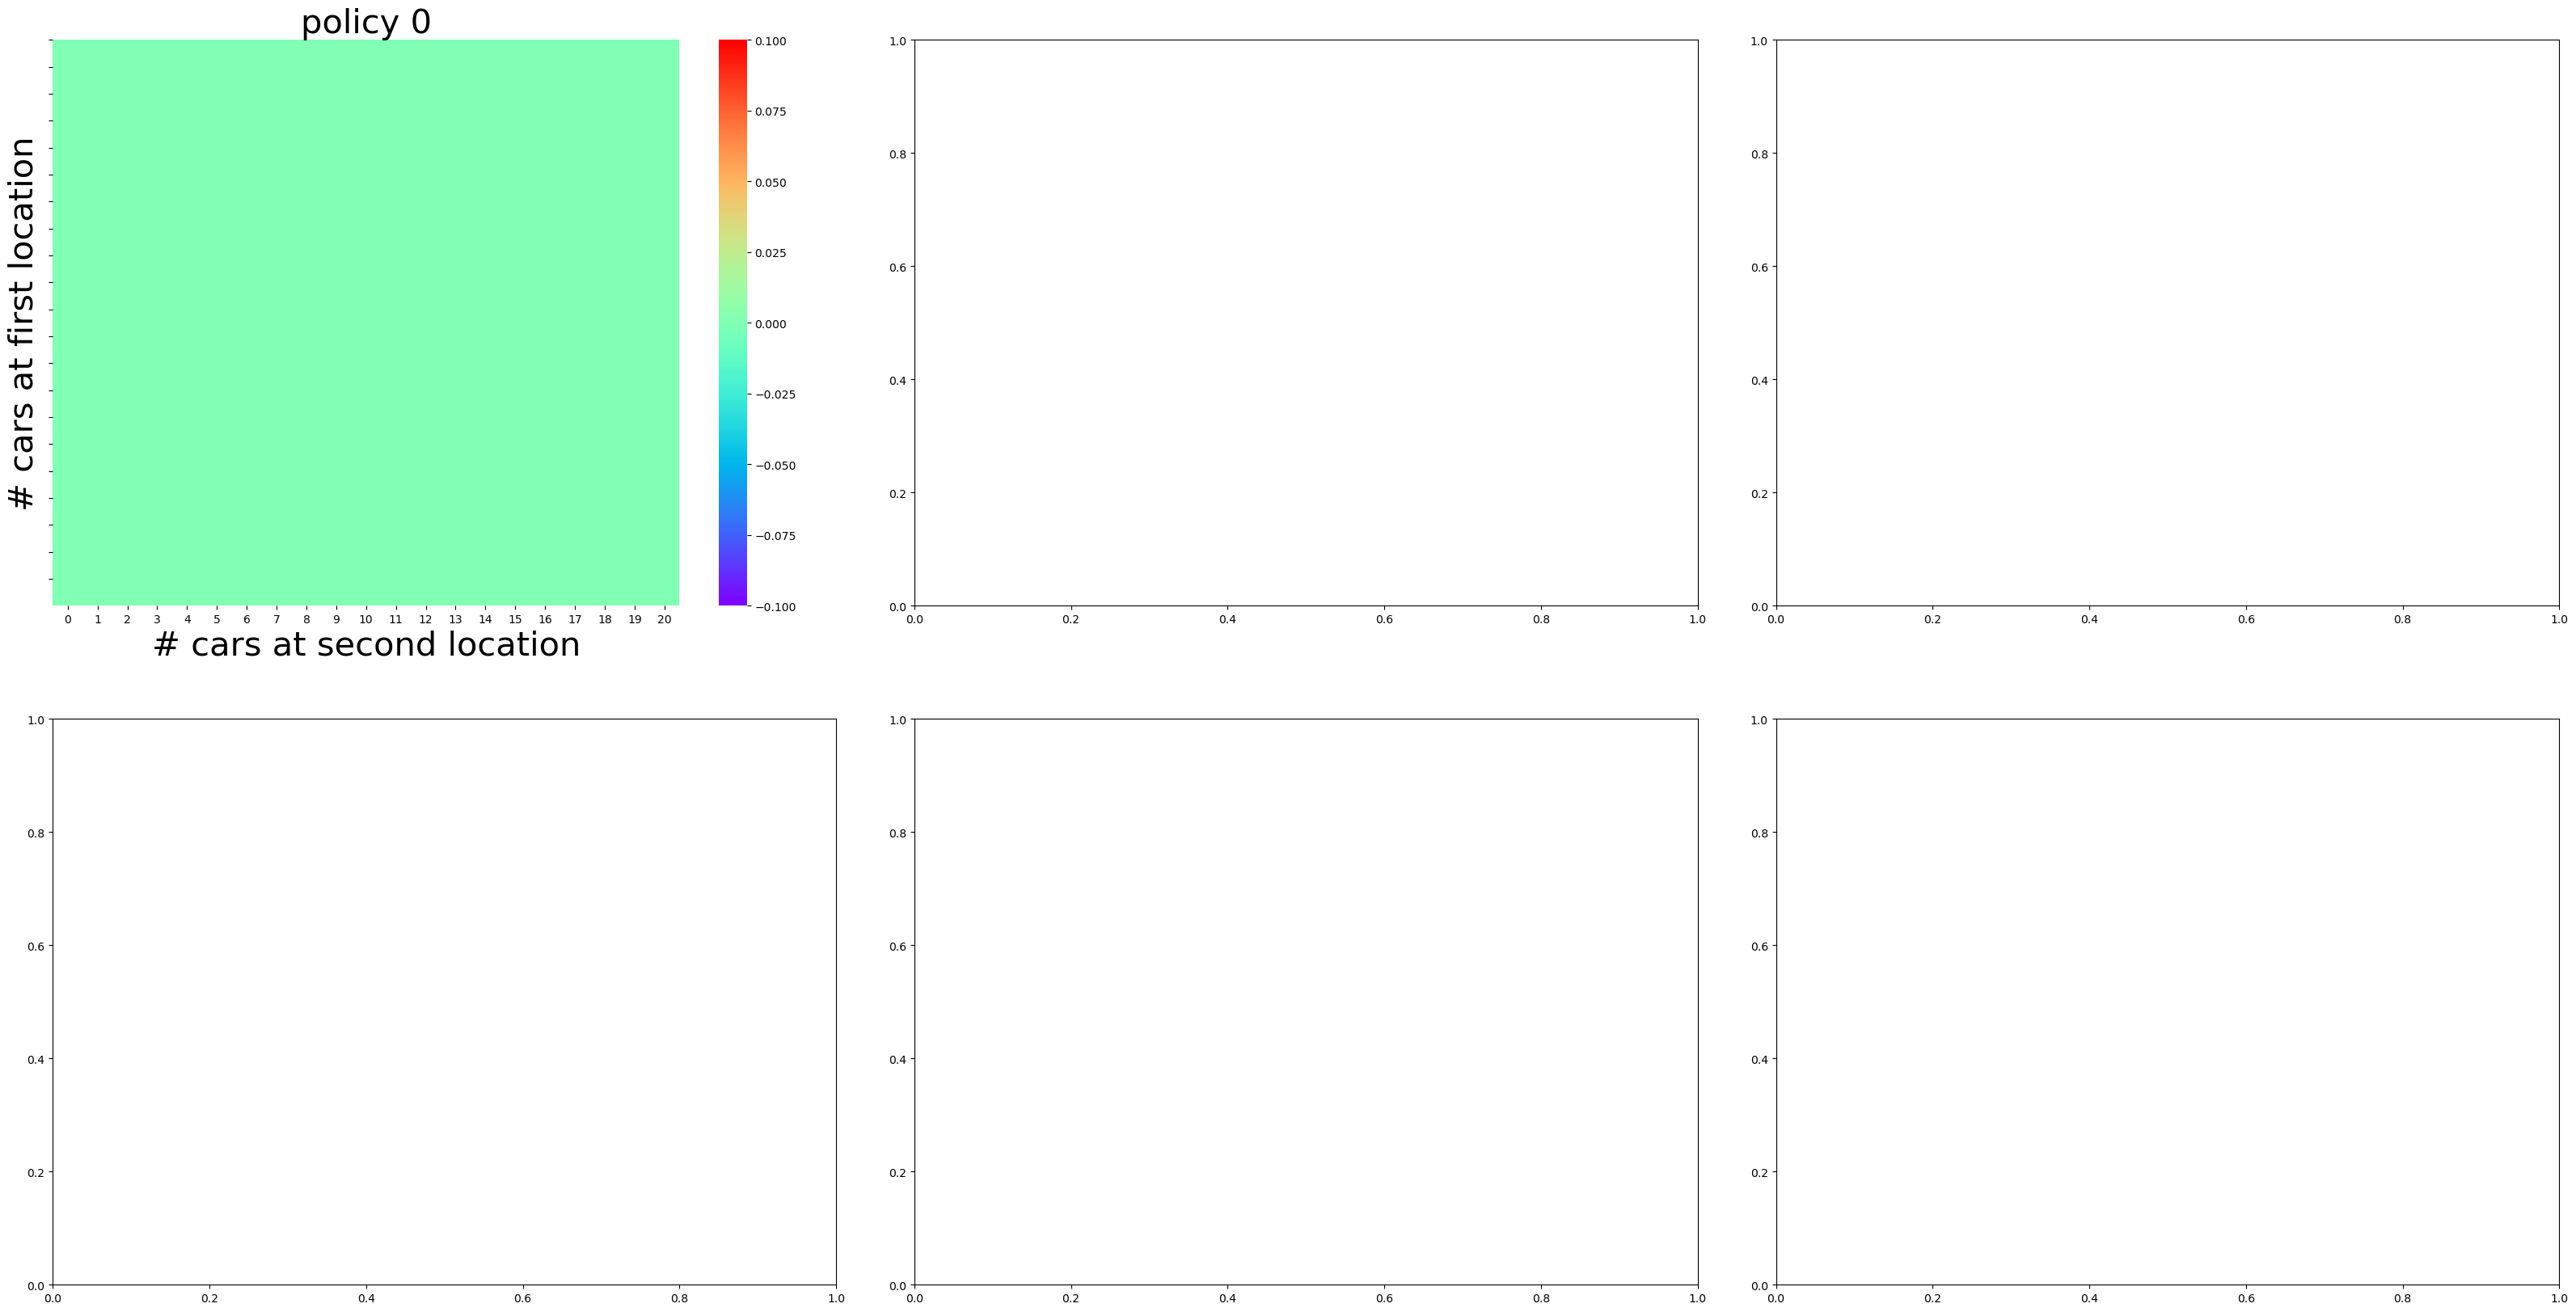

In [10]:
model=dp()
model.policy_iteration(constant_returned_cars=False)